## Imports

In [1]:
from functools import partial

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib as mpl
import numpy as np
import scipy.stats

In [3]:
from wlcsim.analytical import homolog
# from wlcsim.analytical.homolog import *

In [4]:
def map_not_none(f, iterable, **kwargs):
    return [x for x in map(partial(f, **kwargs), iterable) if x is not None]

## Parameters

In [5]:
L = 100
mu = 5
num_cells = 1000000
label_loc = (1/3) * L

b = 3  # max plateau is "farthest linear" Ndel=2*L => 4*b**2*L
nuc_radius = 3500  # whatever man, a little less than max plateau

## Generate Cells/Distances/Etc

### Cells/Neighbors

In [6]:
cells = [homolog.generate_poisson_homologs(mu=mu, chr_size=L) for i in range(num_cells)]

In [7]:
from wlcsim.analytical.homolog import get_neighbors

In [8]:
neighbors = map_not_none(get_neighbors, cells, label_loc=label_loc)

In [9]:
from wlcsim.analytical.homolog import (is_linkless, is_linear, is_ring, 
                                       P_is_linkless, P_is_linear, P_is_ring)

In [10]:
frac_empty = np.mean([*map(is_linkless, neighbors)])
frac_linear = np.mean([*map(is_linear, neighbors)])
frac_ring = np.mean([*map(is_ring, neighbors)])

In [11]:
f"frac_empty is: {frac_empty} ~ {scipy.stats.poisson.pmf(0, mu)} ~ {P_is_linkless(mu)}"

'frac_empty is: 0.006726 ~ 0.006737946999085467 ~ 0.006737946999085467'

In [12]:
f"frac_ring is: {frac_ring} ~ {P_is_ring(mu, label_loc, L)}"

'frac_ring is: 0.782982 ~ 0.7821883508142712'

In [13]:
f"frac_linear ({frac_linear}) is what's left: {P_is_linear(mu, label_loc, L)}"

"frac_linear (0.210292) is what's left: 0.21107370218664334"

### Polymer length, N

In [14]:
from wlcsim.analytical.homolog import get_N, get_N_ring, get_N_linear

In [15]:
Ns = map_not_none(get_N, neighbors, L=L)
Ns_ring = map_not_none(get_N_ring, neighbors)
Ns_linear = map_not_none(get_N_linear, neighbors, L=L)

Analytically, we can .... type this up later....

In [16]:
from wlcsim.analytical.homolog import P_N, P_N_linear, P_N_ring

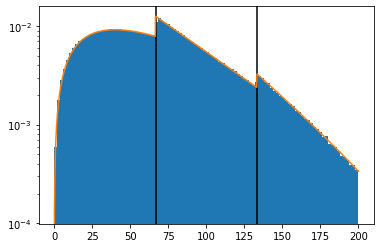

In [17]:
bins = np.arange(0, 2*L + 1, 2)
density, bins, _ = plt.hist(Ns, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N(N, mu, label_loc, L))

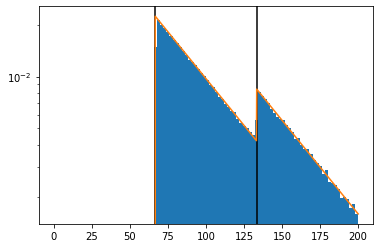

In [18]:
_, _, _ = plt.hist(Ns_linear, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N_linear(N, mu, label_loc, L))

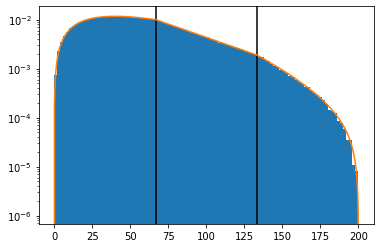

In [19]:
_, _, _ = plt.hist(Ns_ring, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N_ring(N, mu, label_loc, L))

### Distance to Linkage, Ndel ($\Delta$)

In [20]:
from wlcsim.analytical.homolog import get_Ndel, get_Ndel_ring, get_Ndel_linear

In [21]:
Ndels = map_not_none(get_Ndel, neighbors, label_loc=label_loc)
Ndels_ring = map_not_none(get_Ndel_ring, neighbors, label_loc=label_loc)
Ndels_linear = map_not_none(get_Ndel_linear, neighbors, label_loc=label_loc)

Analytically, this is the 

$$ P(\text{has left neighbor}) P(\Delta_\text{left} = x | \text{has left neighbor}) 
+ P(\text{no left neighbor}) P(\Delta_\text{right} = x | \text{no left neighbor}) $$

where $ P(\Delta_\text{left} = x) = 0$ for $x > l_0$ and $P(\Delta_\text{right} = x) = 0$ for $x > L - l_0$.

In [22]:
from wlcsim.analytical.homolog import P_Ndel, P_Ndel_linear, P_Ndel_ring

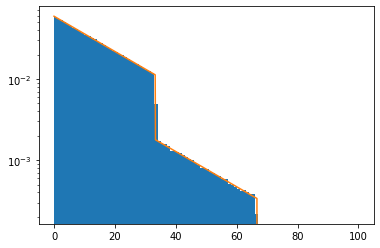

In [23]:
Y, del_bins, _ = plt.hist(Ndels, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel(x, mu, label_loc, L))

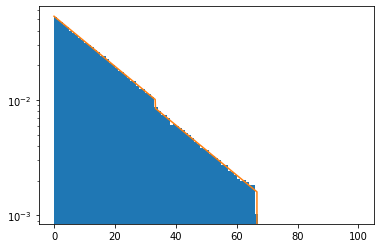

In [24]:
_, _, _ = plt.hist(Ndels_linear, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel_linear(x, mu, label_loc, L))

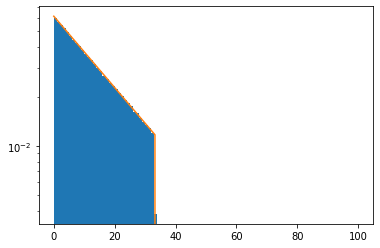

In [25]:
_, _, _ = plt.hist(Ndels_ring, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel_ring(x, mu, label_loc, L))

## Analytically compute

### **JOINT** probability of $\Delta$ and $N$

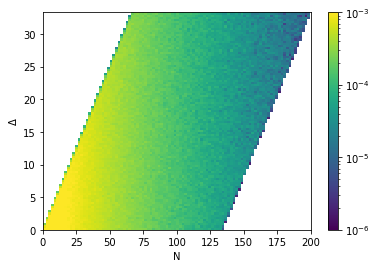

In [26]:
H, xe, ye, im = plt.hist2d(Ns_ring, Ndels_ring, bins=100, density=1, 
                           norm=mcolors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.ylabel('$\Delta$')
plt.xlabel('N')
plt.ylim([0, label_loc])
plt.xlim([0, 2*L])
plt.colorbar()

In [27]:
from wlcsim.analytical.homolog import P_N_joint_Ndel_ring

<ipython-input-28-2a30c015749c>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, P_N_joint_Ndel_ring(xx, yy, mu, label_loc, L)*np.diff(xe)[0]*np.diff(ye)[0],


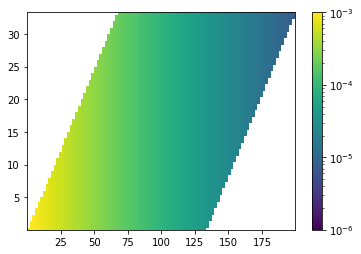

In [28]:
xx, yy = np.meshgrid(xe, ye)
plt.pcolormesh(xx, yy, P_N_joint_Ndel_ring(xx, yy, mu, label_loc, L)*np.diff(xe)[0]*np.diff(ye)[0], 
               norm=mcolors.LogNorm(vmin=1e-6, vmax=1e-3))
plt.colorbar()

### Checking individual integrals

Finally, we check how the analytically determined plateau level compares to the one that comes from averaging many cells together.

In [29]:
# it's a probability, so integrates to 1!
def lower(Ndel):
    return 2*Ndel
def upper(Ndel):
    return 2*(Ndel + L - label_loc)
scipy.integrate.dblquad(P_N_joint_Ndel_ring, 0, label_loc, lower, upper, args=(mu, label_loc, L))

(1.0000000000000002, 1.1102230246251569e-14)

In [31]:
from wlcsim.analytical.homolog import P_Ndel_linear_left, P_Ndel_linear_right

In [33]:
# this guy also integrates to 1
scipy.integrate.quad(P_Ndel_linear_left, 0, label_loc, args=(mu, label_loc, L))

(0.9999999999999998, 1.1102230246251562e-14)

In [34]:
# this guy also integrates to 1
scipy.integrate.quad(P_Ndel_linear_right, 0, L - label_loc, args=(mu, label_loc, L))

(1.0, 1.1102230246251565e-14)

In [35]:
from wlcsim.analytical.homolog import mscd_plateau_ensemble

In [36]:
mscd_plateau_ensemble(mu, label_loc, L, b, nuc_radius)

82815.08876465648

Finally, compare to numerical value via sampling.

In [37]:
hom_plateaus = [homolog.mscd_plateau(linkages, label_loc, L, nuc_radius, b=b) for linkages in cells]

In [38]:
np.mean(hom_plateaus)

82485.16807899646

## Scratch work

If you instead wanted to compute the joint probability function using Bayes rule, and the functions we already have, the only tricky thing you need is $P(\Delta | N, \text{Ring})$.

In [162]:
def P_ring_N(N, mu, l0, L):
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear = P_is_linear(mu, l0, L)*P_N_linear(N, mu, l0, L)
    return ring / (ring + empty + linear)  # faster than "/ P_N()"

def P_linear_N(N, mu, l0, L):
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear = P_is_linear(mu, l0, L)*P_N_linear(N, mu, l0, L)
    return linear / (ring + empty + linear)  # faster than "/ P_N()"

def P_linear_left_N(N, mu, l0, L):
    is_linear_left = P_has_left_only(mu, l0, L)
    is_linear_right = P_has_right_only(mu, l0, L)
    left = is_linear_left / (is_linear_left + is_linear_right)
    right = is_linear_right / (is_linear_left + is_linear_right)
    
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear_left = left*P_N_linear_left_(N, mu, l0, L)
    linear_right = right*P_N_linear_right_(N, mu, l0, L)
    return linear_left / (ring + empty + linear_left + linear_right)

def P_linear_right_N(N, mu, l0, L):
    is_linear_left = P_has_left_only(mu, l0, L)
    is_linear_right = P_has_right_only(mu, l0, L)
    left = is_linear_left / (is_linear_left + is_linear_right)
    right = is_linear_right / (is_linear_left + is_linear_right)
    
    ring = P_is_ring(mu, l0, L)*P_N_ring(N, mu, l0, L)
    empty = P_is_empty(mu)*np.zeros_like(N)
    linear_left = left*P_N_linear_left_(N, mu, l0, L)
    linear_right = right*P_N_linear_right_(N, mu, l0, L)
    return linear_right / (ring + empty + linear_left + linear_right)


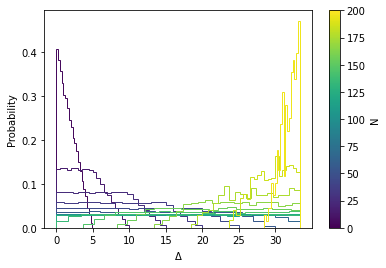

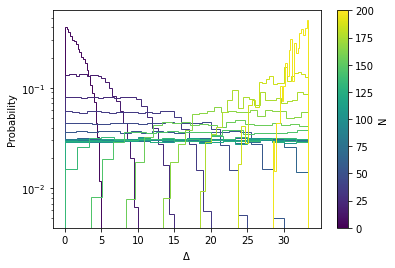

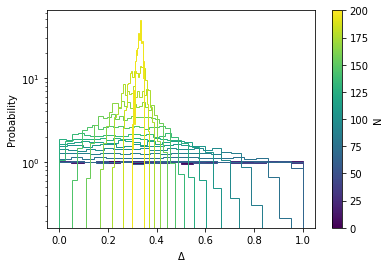

In [161]:
# i = np.argsort(Ns_ring)
# Ns_ring = Ns_ring[i]
# Ndels_ring = Ndels_ring[i]
Ndels_ring = np.array(Ndels_ring)
Ns_ring = np.array(Ns_ring)
scaled_loc = np.array([
    (label_loc - neighbor[0])/(neighbor[1] - neighbor[0]) 
    for neighbor in neighbors if is_ring(neighbor)
])

cmap = mpl.cm.viridis
cnorm_N = mcolors.Normalize(vmin=0, vmax=2*L)

def show_conditional_by_chunk(chunk_size=10, var=Ndels_ring, yscale='linear', split_by=None):
    plt.figure()
    N_bin_edges = np.linspace(0, 2*L, np.round(2*L/chunk_size + 1).astype(int))
    for i, binr in enumerate(N_bin_edges):
        if i == 0:
            continue
        if split_by is not None and i % split_by == 0:
            cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm_N, cmap=cmap))
            cbar.set_label('N')
            plt.xlabel('$\Delta$')
            plt.ylabel('Probability')
            plt.yscale(yscale)
            plt.figure()
        binl = N_bin_edges[i - 1]
        idx = (binl <= Ns_ring) & (Ns_ring < binr)
        plt.hist(var[idx], bins=20, histtype='step', density=1, color=cmap(cnorm_N(np.mean([binr, binl]))))
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=cnorm_N, cmap=cmap))
    cbar.set_label('N')
    plt.xlabel('$\Delta$')
    plt.ylabel('Probability')
    plt.yscale(yscale)
    
show_conditional_by_chunk()
show_conditional_by_chunk(yscale='log')

show_conditional_by_chunk(chunk_size=10, var=scaled_loc, yscale='log')

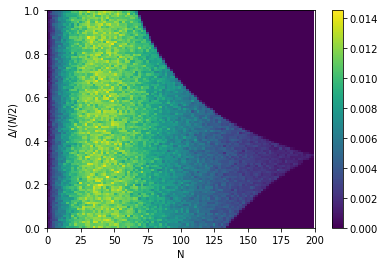

In [118]:
plt.hist2d(Ns_ring, scaled_loc, bins=100, density=1) #, norm=mcolors.LogNorm(vmin=10, vmax=800), bins=100)
plt.ylabel('$\Delta / (N/2)$')
plt.xlabel('N')
plt.ylim([0, 1])
plt.xlim([0, 2*L])
plt.colorbar()

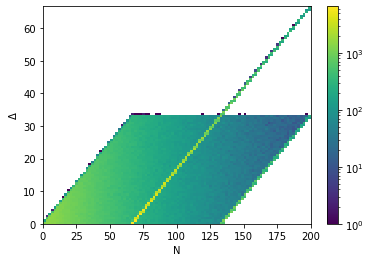

In [120]:
H, xe, ye, im = plt.hist2d(Ns, Ndels, norm=mcolors.LogNorm(), bins=100)
plt.ylabel('$\Delta$')
plt.xlabel('N')
plt.ylim([0, L - label_loc])
plt.xlim([0, 2*L])
plt.colorbar()

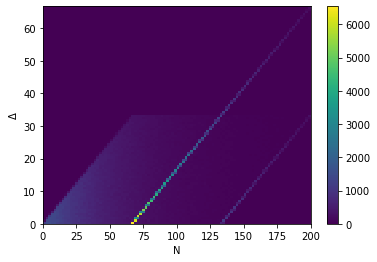

In [122]:
H, xe, ye, im = plt.hist2d(Ns, Ndels, bins=100)
plt.ylabel('$\Delta$')
plt.xlabel('N')
plt.ylim([0, L - label_loc])
plt.xlim([0, 2*L])
plt.colorbar()

Just as a side-note. The reason this is difficult is because the underlying "state" that we're sampling is not a single manifold, but a union of multiple manifolds of dimension 0, 1, and 2:

In [54]:
tLtR = [(-1 if tL is None else tL, -1 if tR is None else tR) for tL, tR in neighbors]
tL = [tL for tL, _ in tLtR]
tR = [tR for _, tR in tLtR]

(Notice in particular that the isolated point (0,0) has probability mass)

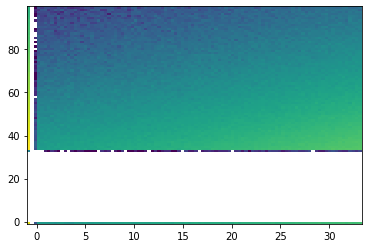

In [55]:
plt.hist2d(tL, tR, bins=100, norm=mcolors.LogNorm());